## Hypothesis Testing

H0: Similarity between benchmark/original passthought and successive pass-thoughts increases with positive feedback  compared to negative feedback
across all fft channels

In [48]:
%matplotlib inline 
#Importations
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial import distance


In [49]:
#Variables
folder = "../../data_mrt/"
files = ['always_accept_1.csv','always_accept_2.csv','always_accept_3.csv','always_accept_4.csv',
        'always_reject_1.csv','always_reject_2.csv','always_reject_3.csv','always_reject_4.csv',]
data = []
times = []
experiment_stages = ['calibration','set_passthought','authenticate'] # This experiment had 3 stages,  
steps = [1,3,4] #Calibration has 1 step, set_passthought has 3 and auth has 4
passthougt_duration = 8 #passthought last 8 seconds

markers = [' /Marker/BLINK',
           ' /Marker/CalibrationComplete', 
           ' /Marker/ThinkPassthought',
           ' /Marker/BLANK',
           ' /Marker/YouhavesuccessfullysetyourPassthought',
           ' /Marker/ThinkPassthoughttoAunthenticate', 
           ' /Marker/Classifying',
           ' /Marker/AuthenticationSuccessful',
       ]
ffts = [' /muse/elements/raw_fft0',' /muse/elements/raw_fft1',
        ' /muse/elements/raw_fft2',' /muse/elements/raw_fft3']

stages, allsteps, start, end, raw_fft,fft_type,subjects,alldata =[],[],[],[],[],[],[],[]


In [50]:
#Read data into pandas
for file in files:
    print("Appending file : ",file)
    filedata = pd.read_csv(folder+file)
    data.append(filedata)

Appending file :  always_accept_1.csv
Appending file :  always_accept_2.csv


//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Appending file :  always_accept_3.csv
Appending file :  always_accept_4.csv


//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Appending file :  always_reject_1.csv
Appending file :  always_reject_2.csv
Appending file :  always_reject_3.csv
Appending file :  always_reject_4.csv


In [87]:
#Methods

#Given two vectors this function returns the cosine similarity
def cosine(X,Y):
    dist = distance.cosine(X,Y)
    return dist


#Function that compares the cosine similarity between 2 groups
def cos_compare(fft_type, step,subject):
    #Set-Passthought will be our comparison session
    #Select all fft segnals in that period and get the mean across all 129 
    set_passthought_signals = df[(df['stage']=='set_passthought') 
                                 &(df['fft_type'] == ' /muse/elements/raw_fft1')
                                 &(df['subject'] == subject)]['raw_fft']

    #put mean signals from the 3 set passthought timeperiods into one dataframe
    mylist = [x.applymap(float).mean(axis=0) for x in set_passthought_signals ] 
    dataframe = pd.DataFrame(data=mylist) #Convert the list to a dataframe
    benchmark = dataframe.mean(axis=0) #Take the mean across the 3 sessions
    benchmark.shape

    
    comparison_group = (df[(df['stage']=="authenticate") &(df['fft_type'] == fft_type) 
                           &(df['step'] == step) &(df['subject'] == subject)] )['raw_fft']
    mylist2 = [x.applymap(float).mean(axis=0) for x in comparison_group ] 
    dataframe2 = pd.DataFrame(data=mylist2) #Convert the list to a dataframe
    comparison_group = dataframe2.mean(axis=0) #Take the mean across the 3 sessions
    comparison_group.shape
    return cosine(benchmark,comparison_group)

def get_markers(mydata):
    my_dict = {}
    for marker in markers:
        #extract the time when the marker was displayed
        time = mydata.loc[mydata["task"] == marker]['time']
        #Save marker and times 
        #print(marker,list(time))
        my_dict[marker] = list(time)
        
    if len(my_dict[' /Marker/BLANK'])>2:
        my_dict[' /Marker/BLANK'] = my_dict[' /Marker/BLANK'][1:-1]

    my_dict['set_passthought_marker'] = my_dict[' /Marker/BLANK'] + my_dict[' /Marker/YouhavesuccessfullysetyourPassthought']

    return my_dict


def filtering(start_time,end_time,f,mydata):
    filtered = mydata[(mydata["time"] >= start_time) & (mydata["time"] <= end_time)] #filter by time
    filtered_fft =filtered[filtered["task"]== f] #filter the relevant fft 
    fft= filtered_fft.iloc[:,2:131]#select the 129 fft columns from the 2nd one to the end
    return fft

def append_elements(stage,s,fft,start_time,end_time,f,subject):
    stages.append(stage)
    allsteps.append(s)
    raw_fft.append(fft)
    start.append(start_time)
    end.append(end_time)
    fft_type.append(f)
    subjects.append(subject)
    
def extract_fft(subjectID,my_dict, mydata):
    #extract all the fft signals for each stage
    for stage in experiment_stages:
        n_steps = steps[experiment_stages.index(stage)] #no of steps per stage
        for s in range(n_steps):
            for f in ffts:
                if stage == "calibration":
                    start_time = my_dict[' /Marker/BLINK'][s]
                    end_time   = my_dict[' /Marker/CalibrationComplete'][s]
                    fft = filtering(start_time,end_time,f,mydata)
                    append_elements(stage,s,fft,start_time,end_time,f,subjectID)
                    
                elif stage == "set_passthought":
                    start_time = my_dict[' /Marker/ThinkPassthought'][s]
                    end_time   = my_dict['set_passthought_marker'][s]
                    fft = filtering(start_time,end_time,f,mydata)
                    append_elements(stage,s,fft,start_time,end_time,f,subjectID)
                    
                elif stage == "authenticate":
                    start_time = my_dict[' /Marker/ThinkPassthoughttoAunthenticate'][s]
                    end_time   = my_dict[' /Marker/Classifying'][s]
                    fft = filtering(start_time,end_time,f,mydata)
                    append_elements(stage,s,fft,start_time,end_time,f,subjectID)
                    
                else:
                    print('Error!!!')
                    

In [88]:
for subjectID in range(len(data)):
    mydata=data[subjectID]
    my_dict = get_markers(mydata)
    extract_fft(subjectID,my_dict, mydata)

    
d = {'stage': stages, 'step': allsteps,
     'start':start ,'end':end,
     'fft_type':fft_type,'raw_fft':raw_fft,'subject':subjects}

df = pd.DataFrame(data=d, columns=['stage','step','fft_type','start','end','raw_fft','subject'])
df.head()   


,stage,step,fft_type,start,end,raw_fft,subject
0,calibration,0,/muse/elements/raw_fft0,1515093498,1515093508,v1 v2 v3 ...,0
1,calibration,0,/muse/elements/raw_fft1,1515093498,1515093508,v1 v2 v3 ...,0
2,calibration,0,/muse/elements/raw_fft2,1515093498,1515093508,v1 v2 v3 ...,0
3,calibration,0,/muse/elements/raw_fft3,1515093498,1515093508,v1 v2 v3 ...,0
4,set_passthought,0,/muse/elements/raw_fft0,1515093583,1515093591,v1 v2 v3 ...,0


In [89]:
df['subject'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [90]:
cosinedata = []
for subjectID in range(len(data)):
    for f in ffts:
        d = [cos_compare(f,step,subjectID) for step in range(steps[2]) ]
        d.append(subjectID)
        d.append(f)
        cosinedata.append(d) 

In [91]:
#cosinedata

In [94]:
df2 = pd.DataFrame(data=cosinedata, columns=['A1','A2','A3','A4','Subject','fft_type'])
df2.head()

,A1,A2,A3,A4,Subject,fft_type
0,0.083359,0.039856,0.062492,0.050730,0,/muse/elements/raw_fft0
1,0.007259,0.008642,0.007571,0.007095,0,/muse/elements/raw_fft1
2,0.015324,0.006995,0.009338,0.008507,0,/muse/elements/raw_fft2
3,0.083837,0.040649,0.059552,0.051747,0,/muse/elements/raw_fft3
4,0.125867,0.123437,0.091967,0.120547,1,/muse/elements/raw_fft0


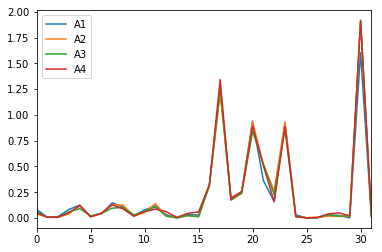

In [95]:
df3 = df2[['A1','A2','A3','A4']]
plt.figure(); df3.plot();

In [97]:
df3.to_csv("cosine.csv")

In [ ]:
df3.to_csv("cosine.csv")